## 데이터 시각화(2)
### 지역 관점으로 EDA
- 지역별로는 어떻게 봐야할까?
    - 좌표는 달려있음
        - Reverse Geocoding : 위도/경도 => 주소로 변환
        - API를 날려야할까?
            - BigQuery GIS엔 shp 파일을 Join해서 찾아내는 기능이 있음


- Shp 파일
    - `bigquery-public-data.geo_us_boundaries.zip_codes`에 저장됨
    - pickup_longitude, pickup_latitude가 zip_code_geom에 속하면 그 지역
- BigQuery GIS
    - [공식 문서](https://cloud.google.com/bigquery/docs/gis-intro?hl=ko)
    - [Geography functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

In [1]:
from chart_studio.plotly import iplot
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(cf.__version__)
cf.go_offline()
%config InlineBackend.figure_format = 'retina'

0.17.3


In [4]:
%%time

query = """
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df = pd.read_gbq(query=query, dialect='standard', project_id='nyc-taxi-demand-predict')


Downloading: 100%|███████████████████████████████████████████████████████████| 87020/87020 [01:16<00:00, 1135.82rows/s]


Wall time: 1min 18s


In [5]:
df.tail()

,zip_code,city,zip_code_geom,pickup_hour,cnt
87015,10463,New York city,"POLYGON((-73.924974 40.879144, -73.92465 40.87...",2015-01-31 23:00:00,1
87016,10016,New York city,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",2015-01-31 23:00:00,1640
87017,10020,New York city,"MULTIPOLYGON(((-73.983263 40.761094, -73.98373...",2015-01-31 23:00:00,66
87018,10038,New York city,"POLYGON((-74.009988 40.709806, -74.010542 40.7...",2015-01-31 23:00:00,164
87019,11373,New York city,"POLYGON((-73.891746 40.742138, -73.891337 40.7...",2015-01-31 23:00:00,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
zip_code         87020 non-null object
city             87020 non-null object
zip_code_geom    87020 non-null object
pickup_hour      87020 non-null datetime64[ns]
cnt              87020 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Trip이 많은 zip_code는?

In [7]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [8]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831


- zip_code별로 빈부격차가 있는 것 같다

In [9]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']

In [10]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708,0.003
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112,0.007
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903,0.021
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908,0.031
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053


In [11]:
zip_code_agg_df.tail()

,zip_code,zip_code_geom,cnt,percent
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [12]:
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

In [13]:
filter_agg_df['cnt'].sum()

12197865

In [14]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [15]:
zip_code_agg_df['cnt'].sum()

12322300

In [16]:
filter_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
200,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",61907,0.005
204,11215,"POLYGON((-74.000995 40.654067, -74.002144 40.6...",12420,0.001
206,11217,"POLYGON((-73.990424 40.682694, -73.990867 40.6...",22778,0.002
211,11222,"POLYGON((-73.962672 40.736446, -73.962668 40.7...",13370,0.001
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001
273,11430,"POLYGON((-73.832705 40.665406, -73.831781 40.6...",233390,0.019


In [17]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [18]:
filter_agg_df.to_csv("zip_code_ratio.csv", index=False)

### Kepler.gl에서 시각화
- [Kepler.gl](https://kepler.gl/demo)
- <img src="https://www.dropbox.com/s/v18lb654qhrqx9l/Screenshot%202019-10-12%2016.01.45.png?raw=1">

- 좌측의 Fill Color 옆에 있는 점 3개 클릭
    - Select a field에 percent 클릭
<img src="https://www.dropbox.com/s/g0iautf1tb55y89/Screenshot%202019-10-12%2016.03.24.png?raw=1">

In [19]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]

In [20]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

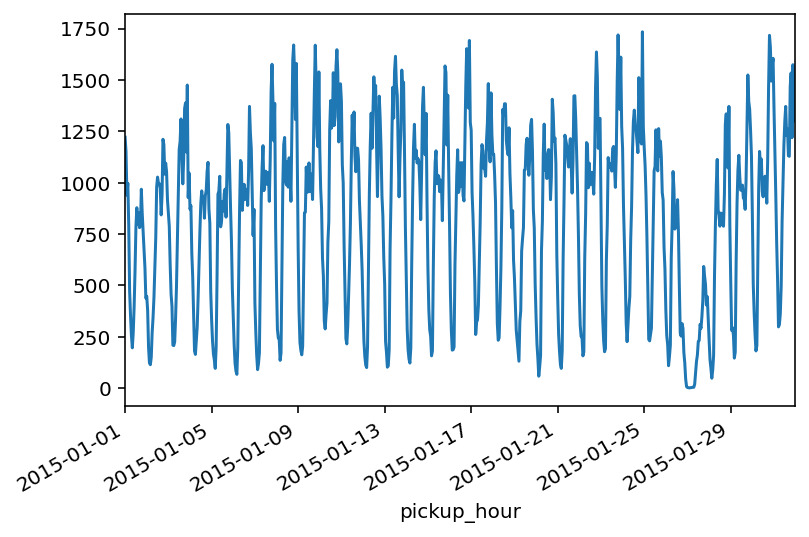

In [21]:
zip_df[zip_df['zip_code'] == '10001'].set_index('pickup_hour')['cnt'].plot();

- cnt가 유난히 낮은 날은 폭설때문

### 하루 단위 zip_code별 Trip Box Plot

In [22]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]

In [23]:
filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()

In [24]:
# cufflinks => 드래그로 가능
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

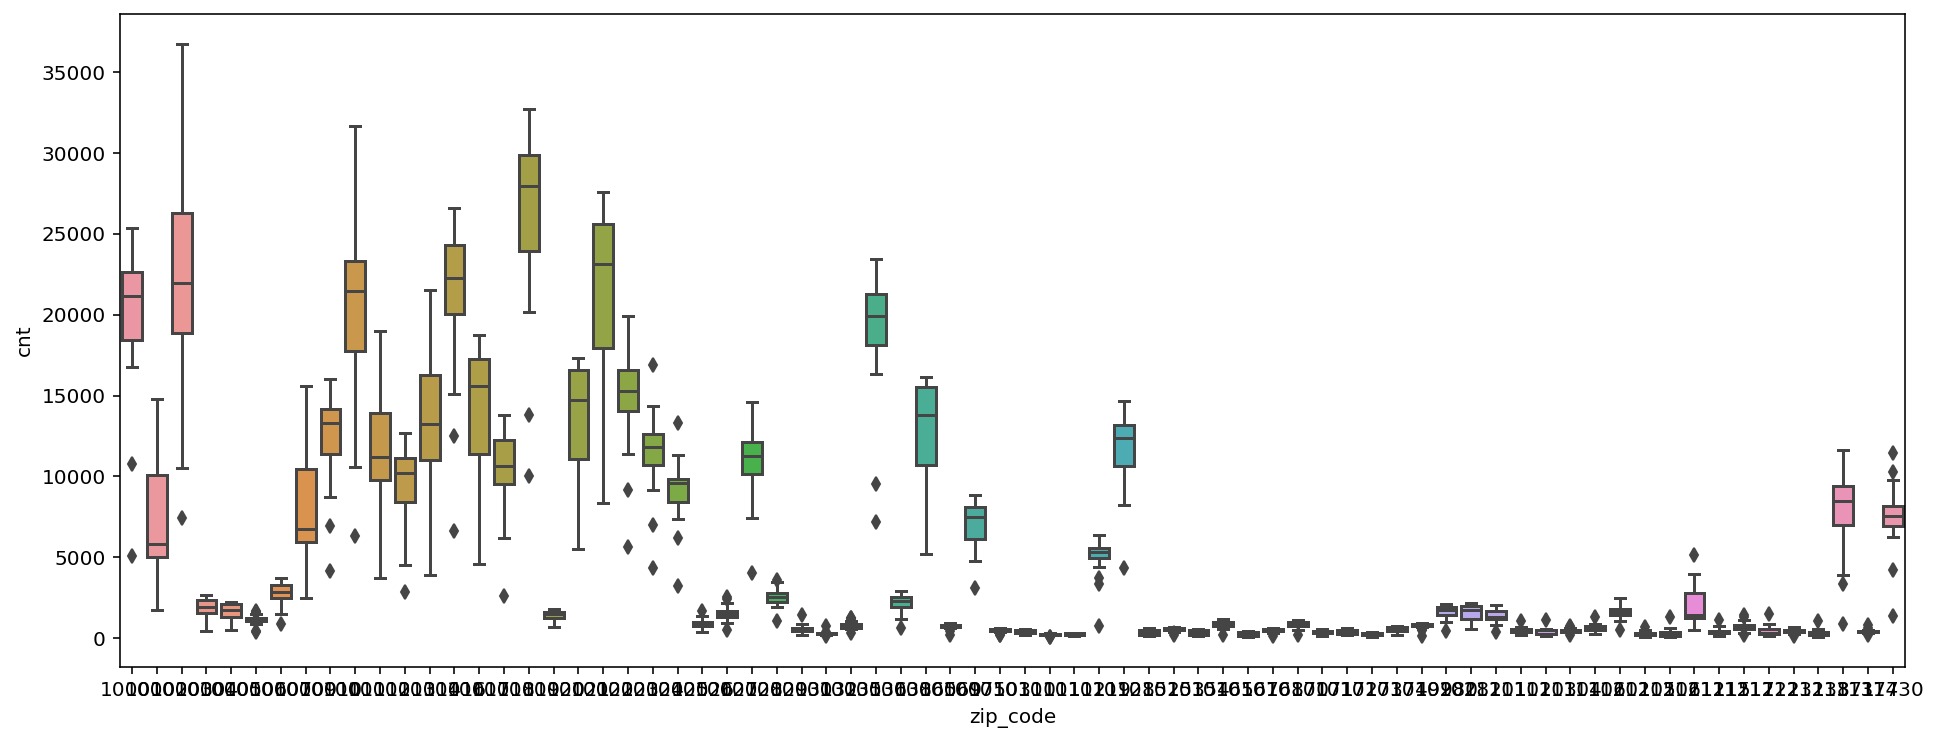

In [26]:
# seaborn
plt.figure(figsize=(16, 6))
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df)

In [27]:
filter_zip_df[filter_zip_df['zip_code'] == '10001']

,zip_code,zip_code_geom,pickup_hour,cnt,date
124,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
174,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
312,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
532,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
658,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01
...,...,...,...,...,...
86509,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 19:00:00,1534,2015-01-31
86597,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 20:00:00,1219,2015-01-31
86680,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 21:00:00,1574,2015-01-31
86878,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 22:00:00,1385,2015-01-31


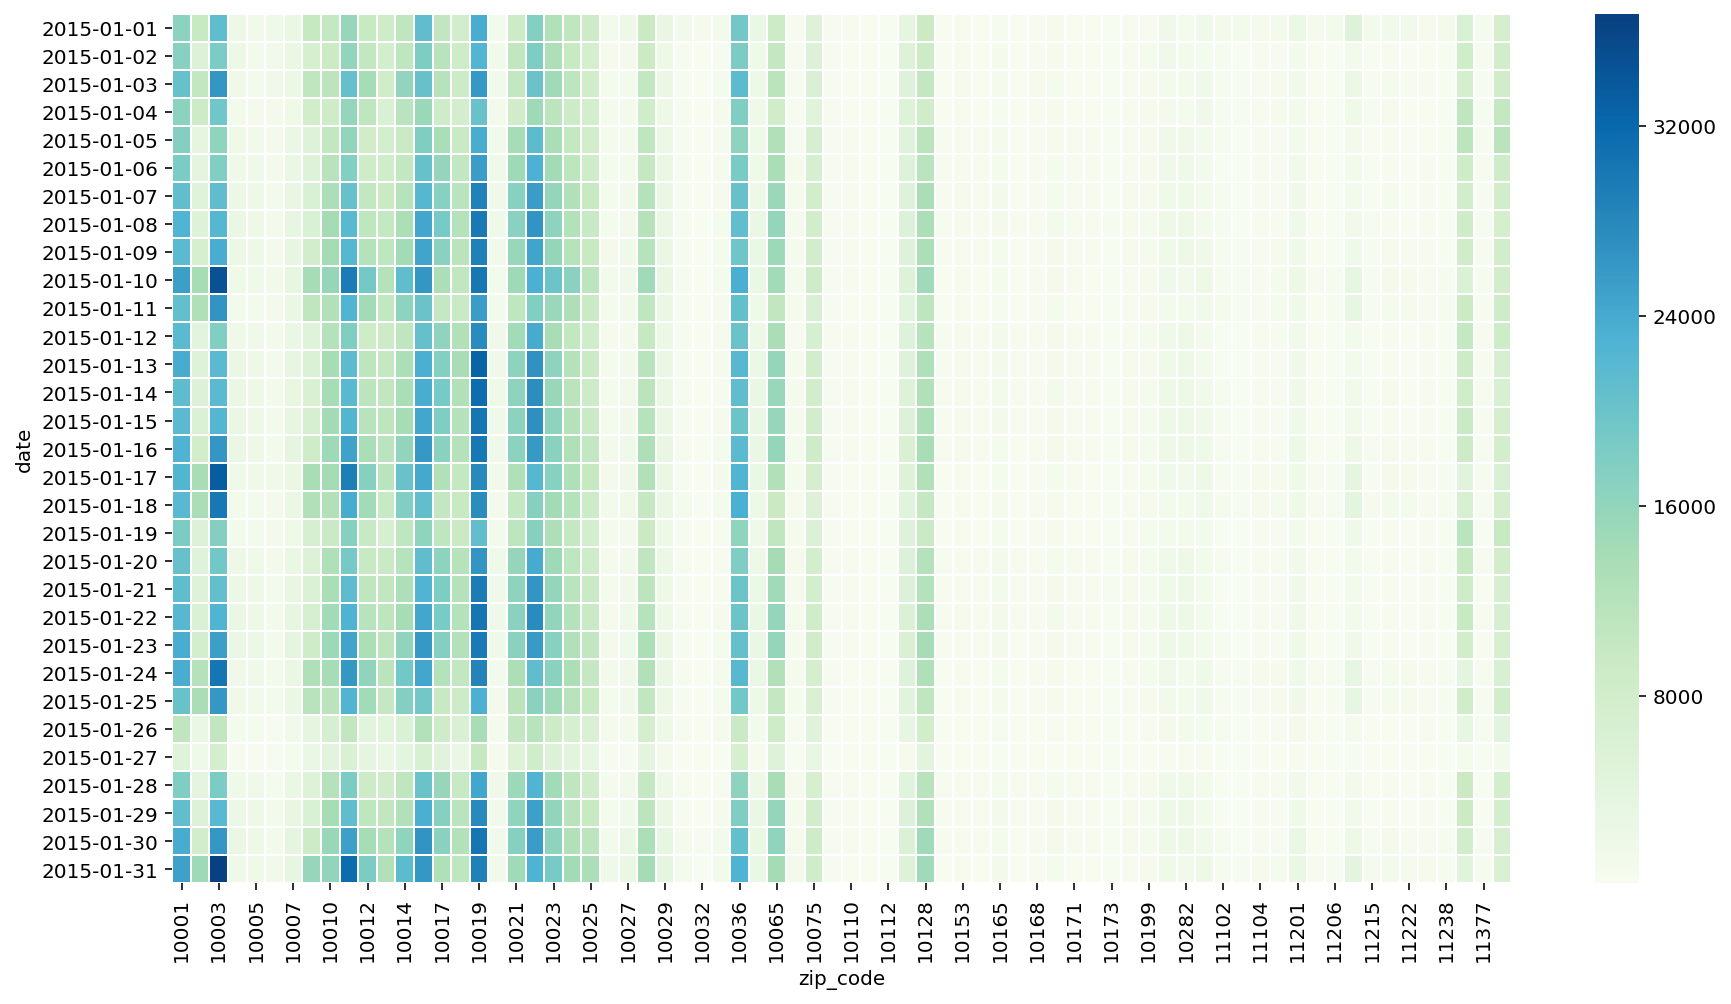

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu');

### 시간대별 zip_code의 추이

In [29]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour

In [30]:
filter_zip_df.head(3)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,10152,"POLYGON((-73.972613 40.759059, -73.973068 40.7...",2015-01-01,15,2015-01-01,0
1,10012,"POLYGON((-74.004575 40.724173, -74.00438 40.72...",2015-01-01,762,2015-01-01,0
2,11102,"POLYGON((-73.937858 40.774088, -73.937813 40.7...",2015-01-01,46,2015-01-01,0


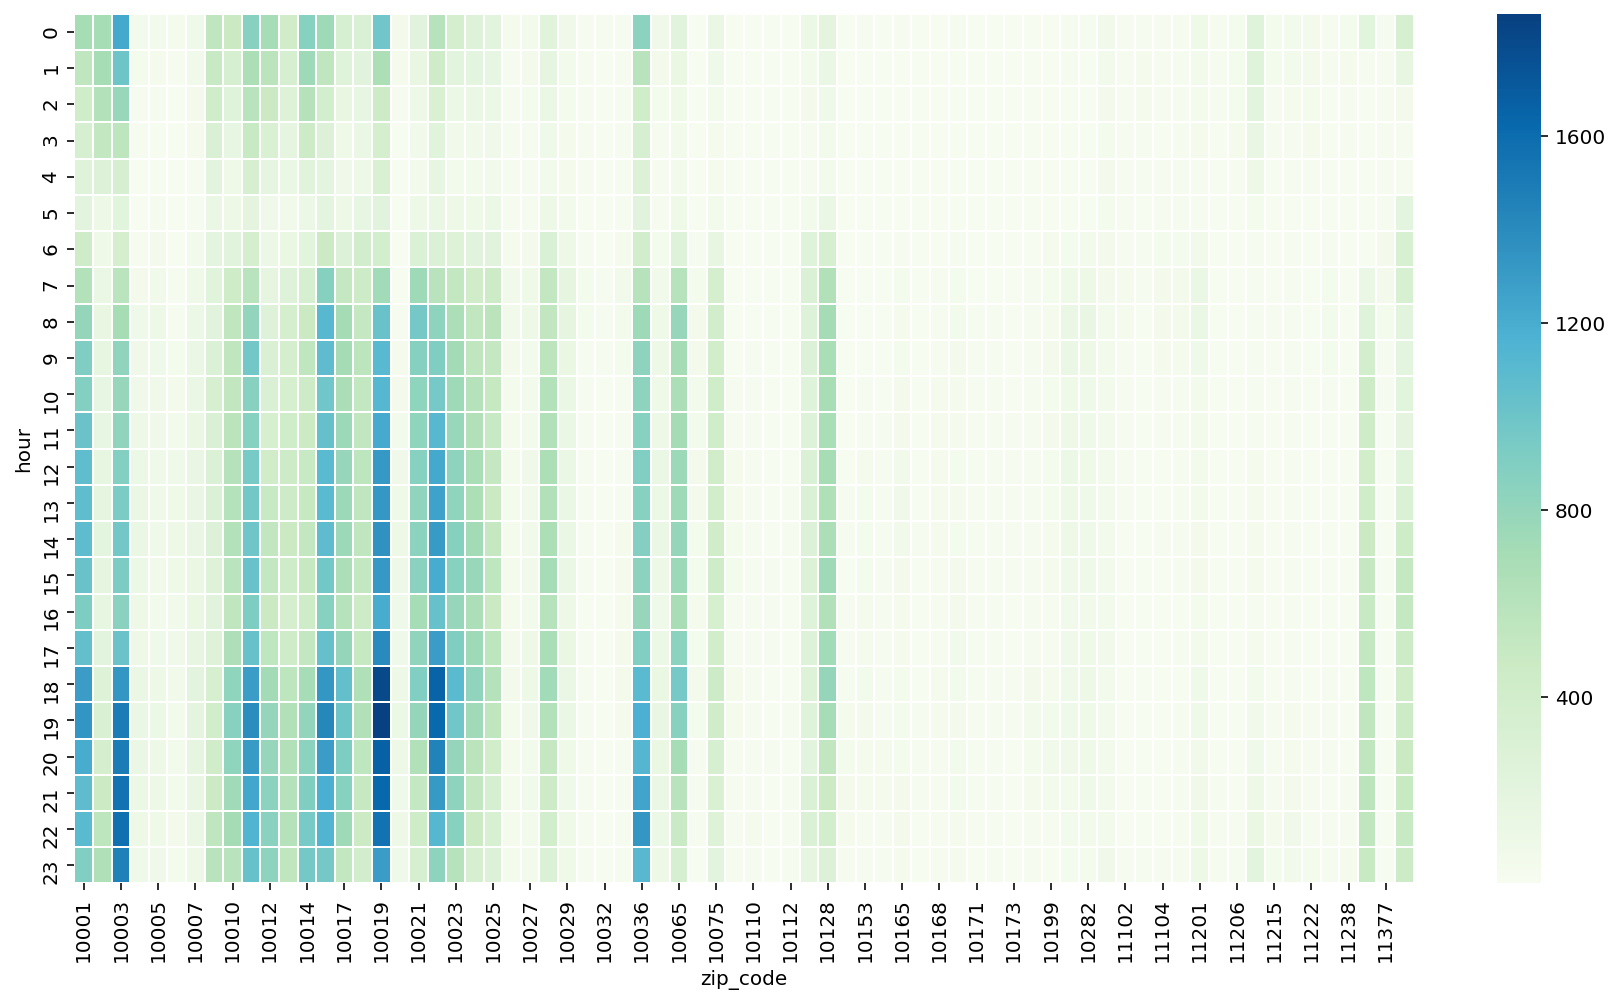

In [31]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu');